# Features definition

**BAD: 1 = client defaulted on loan OR 0 = loan repaid**

**LOAN: Amount of the loan request**

**MORTDUE: Amount due on existing mortgage**

**VALUE: Value of current property**

**REASON: DebtCon = debt consolidation OR HomeImp = home improvement**

**JOB: Six occupational categories**

**YOJ: Years at present job**

**DEROG: Number of major derogatory reports**

**DELINQ: Number of delinquent credit lines**

**CLAGE: Age of oldest trade line in months**

**NINQ: Number of recent credit lines**

**CLNO: Number of credit lines**

**DEBTINC: Debt-to-income ratio**

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Import and inspect dataset

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/BaoLeQuang178/Home-Equity-Loan-analysis/main/data/hmeq.csv')
df_spare = pd.read_csv('https://raw.githubusercontent.com/BaoLeQuang178/Home-Equity-Loan-analysis/main/data/hmeq.csv')

In [3]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


**There are two categorical features, all others are numerical features**

In [5]:
df.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


**There are no anomalies found in the dataset**

In [6]:
df.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')

0    4771
1    1189
Name: BAD, dtype: int64


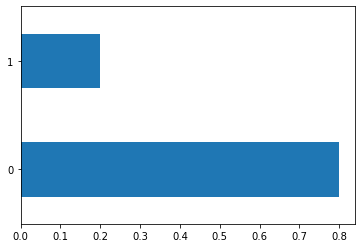

In [7]:
print(df["BAD"].value_counts())
df["BAD"].value_counts(normalize=True).plot(kind="barh")
plt.show()

# Check the distribution of Numerical features

In [8]:
def dist_box(data):
 #function plots a combined graph for univariate analysis of continous variable 
 #to check spread, central tendency , dispersion and outliers  
    Name=data.name.upper()
    fig,(ax_box,ax_dis)  =plt.subplots(nrows=2,sharex=True,gridspec_kw = {"height_ratios": (.25, .75)},figsize=(8, 4.5)) #hàm trả về một bộ giá trị chứa (các) đối tượng hình và trục. 
    mean=data.mean()
    median=data.median()
    mode=data.mode().tolist()[0]
    sns.set_theme(style="white")
    fig.suptitle("SPREAD OF DATA FOR "+ Name  , fontsize=18, fontweight='bold')
    sns.boxplot(x=data,showmeans=True, orient='h',color="violet",ax=ax_box)
    ax_box.set(xlabel='')
     # just trying to make visualisation better. This will set background to white
    sns.despine(top=True,right=True,left=True) # to remove side line from graph
    sns.distplot(data,kde=False,color='blue',ax=ax_dis)
    ax_dis.axvline(mean, color='r', linestyle='--',linewidth=2)
    ax_dis.axvline(median, color='g', linestyle='-',linewidth=2)
    ax_dis.axvline(mode, color='y', linestyle='-',linewidth=2)
    plt.legend({'Mean':mean,'Median':median,'Mode':mode})

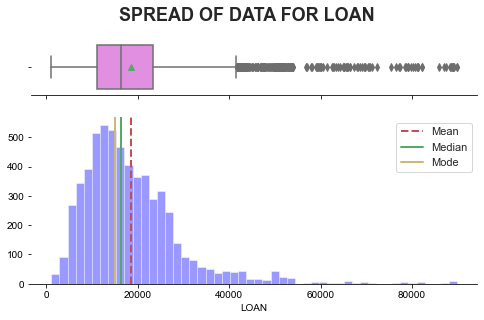

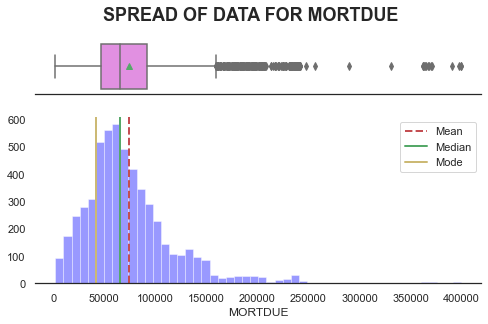

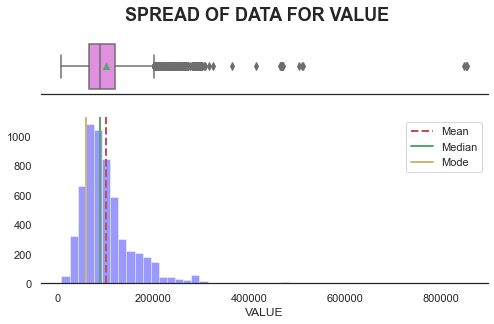

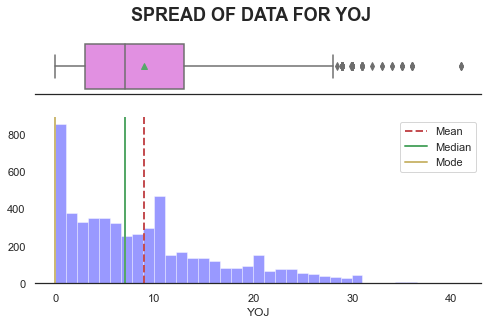

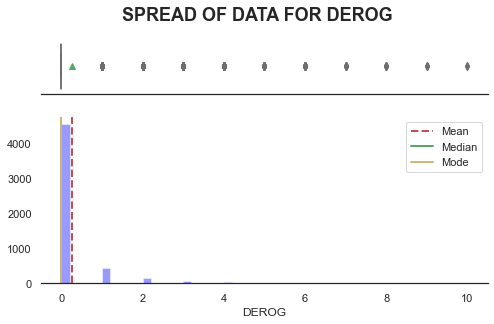

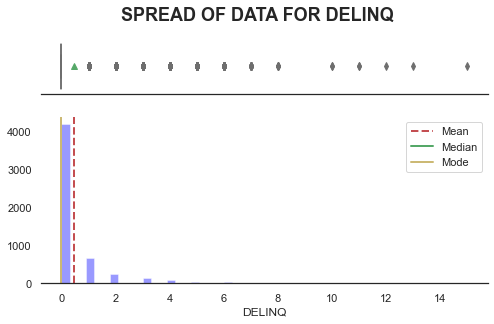

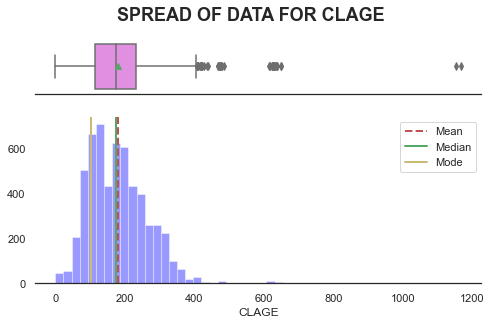

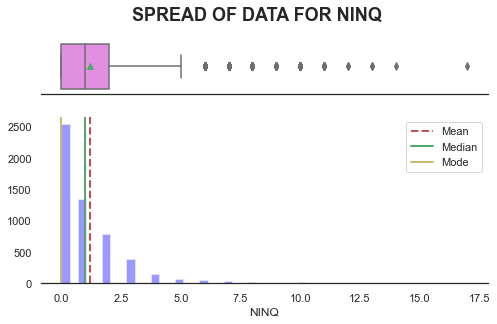

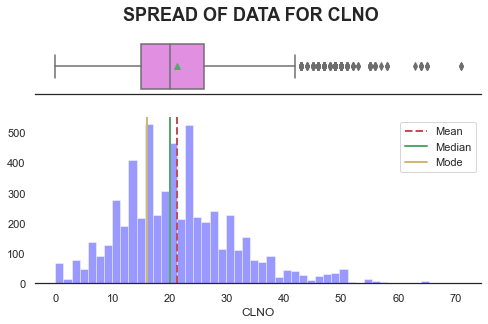

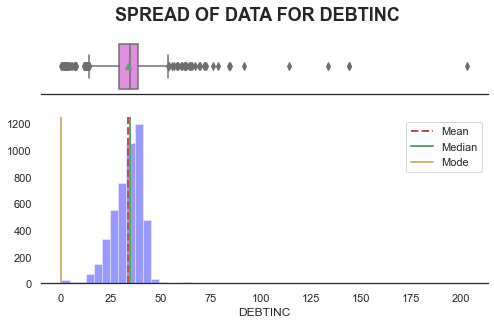

In [9]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
list_col = df.loc[:, df.columns != 'BAD'].select_dtypes(include=numerics).columns.tolist()
for i in range(len(list_col)):
    dist_box(df[list_col[i]])

# Check the distribution of Categorical features

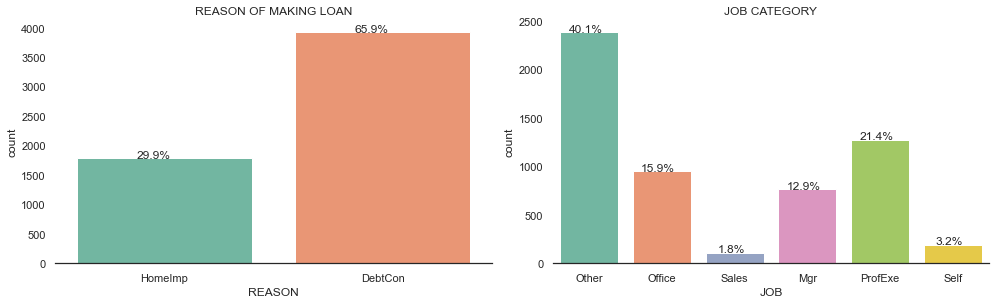

In [10]:
# Making a list of all categorical variables
cat_columns = ['REASON','JOB']
title = ['Reason of Making Loan', 'Job Category']
plt.figure(figsize=(14,20))

sns.set_theme(style="white") # just trying to make visualisation better. This will set background to white
#list_palette=['Blues_r','Greens_r','Purples_r','Reds_r','Blues_r','Greens_r','Purples_r','Reds_r','Blues_r']

for i, variable in enumerate(cat_columns):
    plt.subplot(5,2,i+1)
    order = df[variable].value_counts(ascending=False).index   
    #sns.set_palette(list_palette[i]) # to set the palette
    sns.set_palette('Set2')
    ax=sns.countplot(x=df[variable], data=df )
    sns.despine(top=True,right=True,left=True) 
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/len(df[variable]))
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plt.annotate(percentage, (x, y),ha='center')
    plt.tight_layout()
    plt.title(title[i].upper())

**A lot of customers'job are classified as other**

# Dealing with Missing values with KNN Imputing

In [11]:
for i, col in enumerate(df.columns.tolist()):
    # count number of rows with missing values
    n_miss = df[[col]].isnull().sum()
    perc = n_miss / df.shape[0] * 100
    print('Feature: %s, Missing: %d (%.1f%%) of entire rows' % (str(col), n_miss, perc))

Feature: BAD, Missing: 0 (0.0%) of entire rows
Feature: LOAN, Missing: 0 (0.0%) of entire rows
Feature: MORTDUE, Missing: 518 (8.7%) of entire rows
Feature: VALUE, Missing: 112 (1.9%) of entire rows
Feature: REASON, Missing: 252 (4.2%) of entire rows
Feature: JOB, Missing: 279 (4.7%) of entire rows
Feature: YOJ, Missing: 515 (8.6%) of entire rows
Feature: DEROG, Missing: 708 (11.9%) of entire rows
Feature: DELINQ, Missing: 580 (9.7%) of entire rows
Feature: CLAGE, Missing: 308 (5.2%) of entire rows
Feature: NINQ, Missing: 510 (8.6%) of entire rows
Feature: CLNO, Missing: 222 (3.7%) of entire rows
Feature: DEBTINC, Missing: 1267 (21.3%) of entire rows


**Two features has a lot of missing values (over 10%) including:**

**1. Number of major derogatory reports**

**2. Debt-to-income ratio**

In [12]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


**Encoding categorical variables**

In [13]:
d = {
    'HomeImp': 0,
    'DebtCon': 1,
}
df['REASON'] = df['REASON'].map(d)

In [14]:
e = {
    'Other': 0,
    'Self': 1,
    'Sales': 2,
    'Office': 3,
    'Mgr': 4,
    'ProfExe': 5,
}
df['JOB'] = df['JOB'].map(e)

In [15]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,0.0,0.0,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,0.0,0.0,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,0.0,0.0,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,0.0,3.0,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   float64
 5   JOB      5681 non-null   float64
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(11), int64(2)
memory usage: 605.4 KB


In [17]:
df_1 = df.copy()

In [18]:
imputer = KNNImputer(n_neighbors=5)
df = imputer.fit_transform(df)
df = pd.DataFrame(df)

In [19]:
df_1.columns.tolist()

['BAD',
 'LOAN',
 'MORTDUE',
 'VALUE',
 'REASON',
 'JOB',
 'YOJ',
 'DEROG',
 'DELINQ',
 'CLAGE',
 'NINQ',
 'CLNO',
 'DEBTINC']

In [20]:
df.columns = ['BAD',
 'LOAN',
 'MORTDUE',
 'VALUE',
 'REASON',
 'JOB',
 'YOJ',
 'DEROG',
 'DELINQ',
 'CLAGE',
 'NINQ',
 'CLNO',
 'DEBTINC']

In [21]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1.0,1100.0,25860.0,39025.0,0.0,0.0,10.5,0.0,0.0,94.366667,1.0,9.0,29.994530
1,1.0,1300.0,70053.0,68400.0,0.0,0.0,7.0,0.0,2.0,121.833333,0.0,14.0,40.532794
2,1.0,1500.0,13500.0,16700.0,0.0,0.0,4.0,0.0,0.0,149.466667,1.0,10.0,36.196050
3,1.0,1500.0,48080.6,56090.8,0.0,0.6,6.8,0.0,0.4,110.973073,0.4,10.8,29.512385
4,0.0,1700.0,97800.0,112000.0,0.0,3.0,3.0,0.0,0.0,93.333333,0.0,14.0,34.370509


In [22]:
df.isnull().sum()

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

# Model Deployment with Unscaled dataframe

In [23]:
X = df.drop(columns=["BAD"])
y = df["BAD"]

In [24]:
# Spliting the data into test and train sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =.3,random_state=1)

# Logistic Regression

In [25]:
logreg_basic = LogisticRegression()

# Training the basic logistic regression model with training set 
logreg_basic.fit(X_train, y_train)

# Printing the coefficients
print("intercept ")
print(logreg_basic.intercept_)
print("")
print("coefficients ")
print(logreg_basic.coef_)

# Predicting the output of the test cases using the algorithm created above
y_pre = logreg_basic.predict(X_test)

# Validating the algorithm using various Performance metrics
print("")
a1 = accuracy_score(y_test,y_pre)
f1 = f1_score(y_test, y_pre, average="macro")
p1 = precision_score(y_test, y_pre, average="macro")
r1 = recall_score(y_test, y_pre, average="macro")
print("accuracy score : ",a1)
print("f1 score : ",f1)
print("precision score : ",p1)
print("recall score : ",r1)

intercept 
[-1.55449321e-05]

coefficients 
[[-1.56354030e-05 -2.84646389e-06  7.36073116e-07 -8.90005914e-06
  -4.36248406e-05 -2.32849296e-04  5.85419150e-05  8.45081180e-05
  -5.84803478e-03  7.10226894e-05 -1.87442093e-04 -2.79830757e-04]]

accuracy score :  0.7919463087248322
f1 score :  0.44194756554307113
precision score :  0.3959731543624161
recall score :  0.5


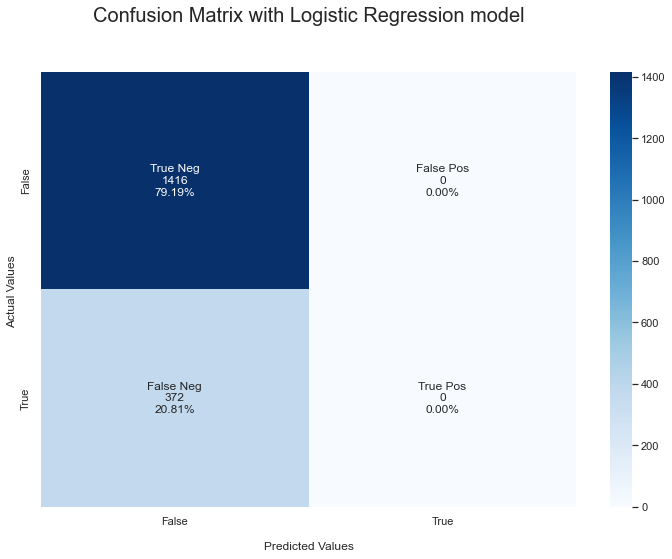

In [26]:
cf_matrix_log = confusion_matrix(y_test, y_pre)
plt.figure(figsize=(12,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_log.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_log.flatten()/np.sum(cf_matrix_log)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix_log, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with Logistic Regression model\n\n',fontsize=20);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

# Decision Tree Classifier

accuracy score :  0.8501118568232662
f1 score :  0.7702887976575578
precision score :  0.7730854765096511
recall score :  0.7676211955531256


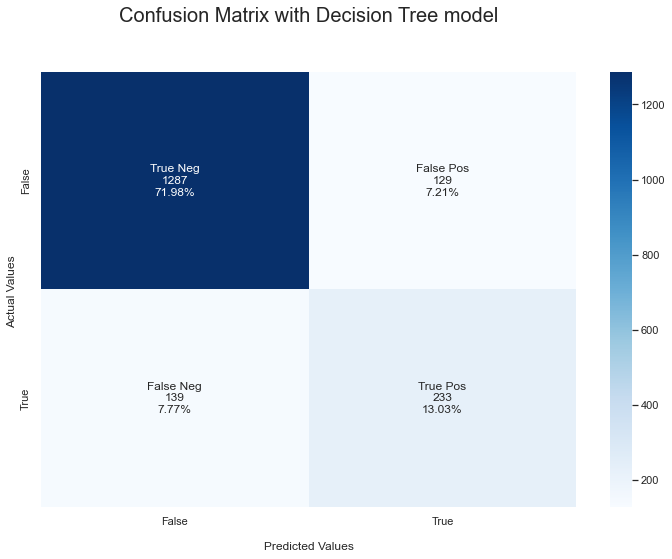

In [27]:
dectree_basic = DecisionTreeClassifier()
# Training the basic Decision Tree model with training set 
dectree_basic.fit(X_train,y_train)

# Predicting the output of the test cases using the algorithm created above
y_pre = dectree_basic.predict(X_test)

# Validating the algorithm using various Performance metrics

a2 = accuracy_score(y_test,y_pre)
f2 = f1_score(y_test, y_pre, average="macro")
p2 = precision_score(y_test, y_pre, average="macro")
r2 = recall_score(y_test, y_pre, average="macro")
print("accuracy score : ",a2)
print("f1 score : ",f2)
print("precision score : ",p2)
print("recall score : ",r2)

# Computing Confusion matrix for the above algorithm
cf_matrix = confusion_matrix(y_test, y_pre)
plt.figure(figsize=(12,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with Decision Tree model\n\n',fontsize=20);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

# XGBoost Classifier

accuracy score :  0.9116331096196868
f1 score :  0.8462469549164358
precision score :  0.9184863459037711
recall score :  0.8054720247858576


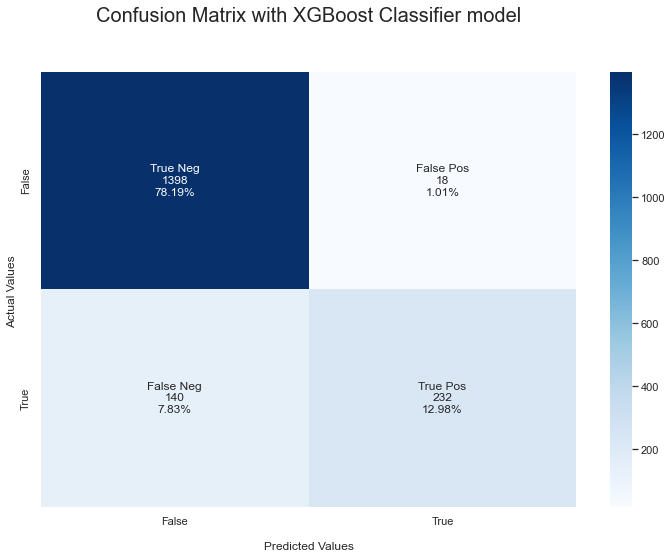

In [28]:
xgb_model = XGBClassifier()
# Training the basic Decision Tree model with training set 
xgb_model.fit(X_train,y_train)

# Predicting the output of the test cases using the algorithm created above
y_pre = xgb_model.predict(X_test)

# Validating the algorithm using various Performance metrics

a3 = accuracy_score(y_test,y_pre)
f3 = f1_score(y_test, y_pre, average="macro")
p3 = precision_score(y_test, y_pre, average="macro")
r3 = recall_score(y_test, y_pre, average="macro")
print("accuracy score : ",a3)
print("f1 score : ",f3)
print("precision score : ",p3)
print("recall score : ",r3)

# Computing Confusion matrix for the above algorithm
cf_matrix = confusion_matrix(y_test, y_pre)
plt.figure(figsize=(12,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with XGBoost Classifier model\n\n',fontsize=20);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

# Multilayer Perceptron Neural Network

accuracy score :  0.7913870246085011
f1 score :  0.4417733374960974
precision score :  0.39591494124230553
recall score :  0.4996468926553672


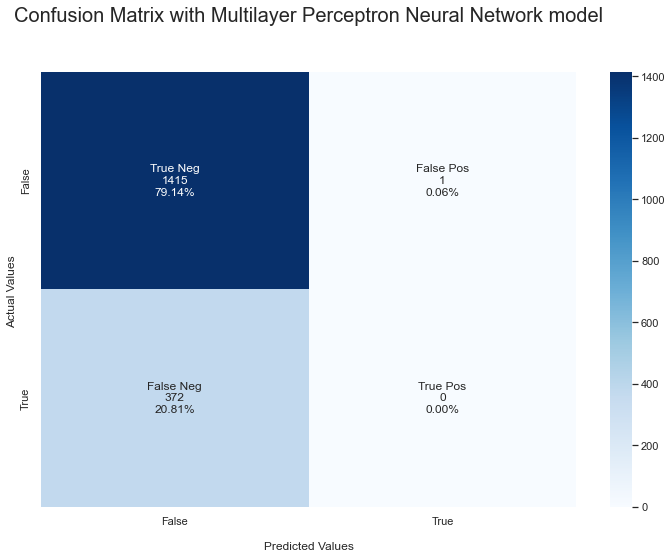

In [29]:
mlp_model = MLPClassifier()
# Training the basic Decision Tree model with training set 
mlp_model.fit(X_train,y_train)

# Predicting the output of the test cases using the algorithm created above
y_pre = mlp_model.predict(X_test)

# Validating the algorithm using various Performance metrics

a4 = accuracy_score(y_test,y_pre)
f4 = f1_score(y_test, y_pre, average="macro")
p4 = precision_score(y_test, y_pre, average="macro")
r4 = recall_score(y_test, y_pre, average="macro")
print("accuracy score : ",a4)
print("f1 score : ",f4)
print("precision score : ",p4)
print("recall score : ",r4)

# Computing Confusion matrix for the above algorithm
cf_matrix = confusion_matrix(y_test, y_pre)
plt.figure(figsize=(12,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with Multilayer Perceptron Neural Network model\n\n',fontsize=20);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

# Support Vector Machine

accuracy score :  0.7930648769574944
f1 score :  0.44757120382648546
precision score :  0.8964165733482643
recall score :  0.5026881720430108


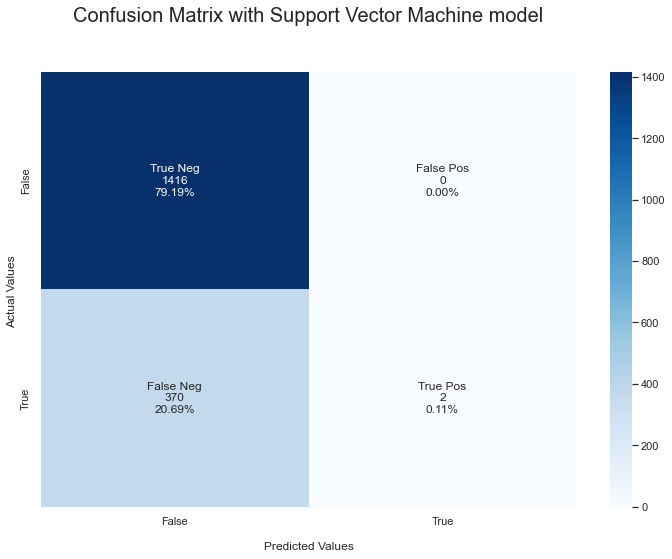

In [30]:
svc_model = SVC()
# Training the basic Decision Tree model with training set 
svc_model.fit(X_train,y_train)

# Predicting the output of the test cases using the algorithm created above
y_pre = svc_model.predict(X_test)

# Validating the algorithm using various Performance metrics

a5 = accuracy_score(y_test,y_pre)
f5 = f1_score(y_test, y_pre, average="macro")
p5 = precision_score(y_test, y_pre, average="macro")
r5 = recall_score(y_test, y_pre, average="macro")
print("accuracy score : ",a5)
print("f1 score : ",f5)
print("precision score : ",p5)
print("recall score : ",r5)

# Computing Confusion matrix for the above algorithm
cf_matrix = confusion_matrix(y_test, y_pre)
plt.figure(figsize=(12,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with Support Vector Machine model\n\n',fontsize=20);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

# Model Deployment with Scaled dataframe

In [31]:
df_scaled = df.copy()

In [32]:
df_scaled

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1.0,1100.0,25860.0,39025.0,0.0,0.0,10.5,0.0,0.0,94.366667,1.0,9.0,29.994530
1,1.0,1300.0,70053.0,68400.0,0.0,0.0,7.0,0.0,2.0,121.833333,0.0,14.0,40.532794
2,1.0,1500.0,13500.0,16700.0,0.0,0.0,4.0,0.0,0.0,149.466667,1.0,10.0,36.196050
3,1.0,1500.0,48080.6,56090.8,0.0,0.6,6.8,0.0,0.4,110.973073,0.4,10.8,29.512385
4,0.0,1700.0,97800.0,112000.0,0.0,3.0,3.0,0.0,0.0,93.333333,0.0,14.0,34.370509
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0.0,88900.0,57264.0,90185.0,1.0,0.0,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0.0,89000.0,54576.0,92937.0,1.0,0.0,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0.0,89200.0,54045.0,92924.0,1.0,0.0,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0.0,89800.0,50370.0,91861.0,1.0,0.0,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


In [33]:
cols_to_scale = df_scaled.drop(['BAD', 'REASON', 'JOB'], axis = 1).columns.tolist()
scaler = StandardScaler()
df_scaled[cols_to_scale] = scaler.fit_transform(df_scaled[cols_to_scale])

**Only original numerical features are to be scaled**

In [34]:
df_scaled.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1.0,-1.562299,-1.088616,-1.086942,0.0,0.0,0.215095,-0.338475,-0.460593,-1.008725,-0.106316,-1.221662,-0.403486
1,1.0,-1.544453,-0.064937,-0.573895,0.0,0.0,-0.259953,-0.338475,1.297980,-0.682308,-0.705335,-0.721835,0.901614
2,1.0,-1.526606,-1.374920,-1.476858,0.0,0.0,-0.667138,-0.338475,-0.460593,-0.353910,-0.106316,-1.121697,0.364535
3,1.0,-1.526606,-0.573901,-0.788881,0.0,0.6,-0.287099,-0.338475,-0.108878,-0.811372,-0.465727,-1.041724,-0.463197
4,0.0,-1.508759,0.577790,0.187597,0.0,3.0,-0.802866,-0.338475,-0.460593,-1.021005,-0.705335,-0.721835,0.138452


In [35]:
X = df_scaled.drop(columns=["BAD"])
y = df_scaled["BAD"]
# Spliting the data into test and train sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =.3,random_state=1)

# Logistic Regression with Scaled dataframe

In [36]:
logreg_basic = LogisticRegression()

# Training the basic logistic regression model with training set 
logreg_basic.fit(X_train, y_train)

# Printing the coefficients
print("intercept ")
print(logreg_basic.intercept_)
print("")
print("coefficients ")
print(logreg_basic.coef_)

# Predicting the output of the test cases using the algorithm created above
y_pre = logreg_basic.predict(X_test)

# Validating the algorithm using various Performance metrics
print("")
a6 = accuracy_score(y_test,y_pre)
f6 = f1_score(y_test, y_pre, average="macro")
p6 = precision_score(y_test, y_pre, average="macro")
r6 = recall_score(y_test, y_pre, average="macro")
print("accuracy score : ",a6)
print("f1 score : ",f6)
print("precision score : ",p6)
print("recall score : ",r6)

intercept 
[-1.44263717]

coefficients 
[[-0.18395184 -0.14214975  0.14857933 -0.21181729 -0.03444059 -0.05055233
   0.38860434  0.60705402 -0.43880106  0.28898124 -0.03865585  0.19863292]]

accuracy score :  0.8204697986577181
f1 score :  0.6117311122882001
precision score :  0.7840845429080723
recall score :  0.5953048113723346


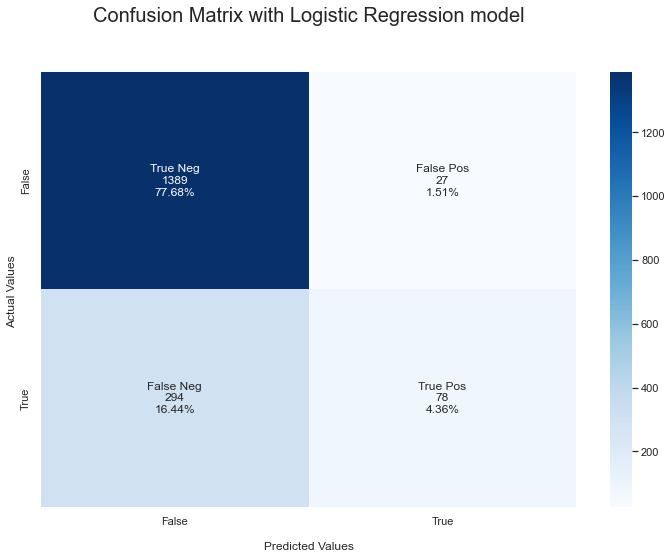

In [37]:
cf_matrix_log = confusion_matrix(y_test, y_pre)
plt.figure(figsize=(12,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_log.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_log.flatten()/np.sum(cf_matrix_log)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix_log, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with Logistic Regression model\n\n',fontsize=20);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

# Decision Tree with Scaled dataframe

accuracy score :  0.8585011185682326
f1 score :  0.7833645813129898
precision score :  0.785991010584312
recall score :  0.780845635137598


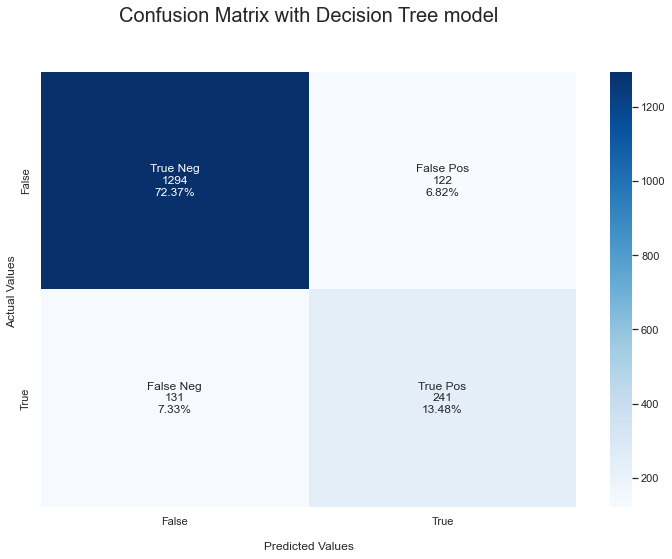

In [38]:
dectree_basic = DecisionTreeClassifier()
# Training the basic Decision Tree model with training set 
dectree_basic.fit(X_train,y_train)

# Predicting the output of the test cases using the algorithm created above
y_pre = dectree_basic.predict(X_test)

# Validating the algorithm using various Performance metrics

a7 = accuracy_score(y_test,y_pre)
f7 = f1_score(y_test, y_pre, average="macro")
p7 = precision_score(y_test, y_pre, average="macro")
r7 = recall_score(y_test, y_pre, average="macro")
print("accuracy score : ",a7)
print("f1 score : ",f7)
print("precision score : ",p7)
print("recall score : ",r7)

# Computing Confusion matrix for the above algorithm
cf_matrix = confusion_matrix(y_test, y_pre)
plt.figure(figsize=(12,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with Decision Tree model\n\n',fontsize=20);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

# XGBoost Classifier with Scaled dataframe¶

accuracy score :  0.9116331096196868
f1 score :  0.8462469549164358
precision score :  0.9184863459037711
recall score :  0.8054720247858576


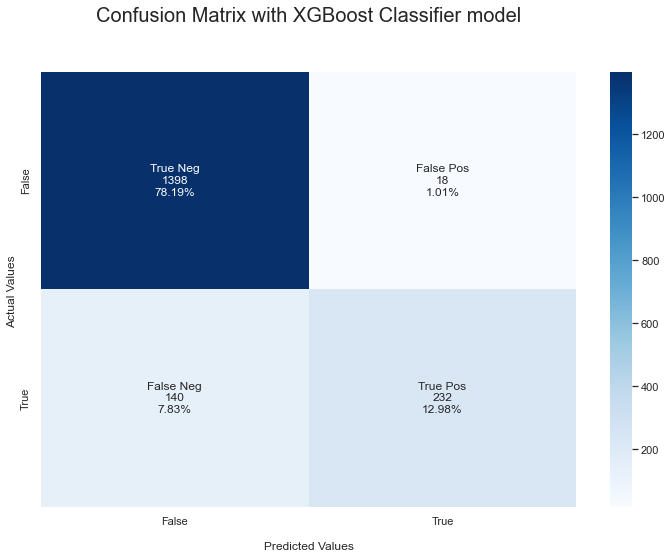

In [39]:
xgb_model = XGBClassifier()
# Training the basic Decision Tree model with training set 
xgb_model.fit(X_train,y_train)

# Predicting the output of the test cases using the algorithm created above
y_pre = xgb_model.predict(X_test)

# Validating the algorithm using various Performance metrics

a8 = accuracy_score(y_test,y_pre)
f8 = f1_score(y_test, y_pre, average="macro")
p8 = precision_score(y_test, y_pre, average="macro")
r8 = recall_score(y_test, y_pre, average="macro")
print("accuracy score : ",a8)
print("f1 score : ",f8)
print("precision score : ",p8)
print("recall score : ",r8)

# Computing Confusion matrix for the above algorithm
cf_matrix = confusion_matrix(y_test, y_pre)
plt.figure(figsize=(12,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with XGBoost Classifier model\n\n',fontsize=20);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

# Multilayer Perceptron Neural Network with Scaled dataframe

accuracy score :  0.8803131991051454
f1 score :  0.780413059796569
precision score :  0.8785261633170378
recall score :  0.7381310369965373


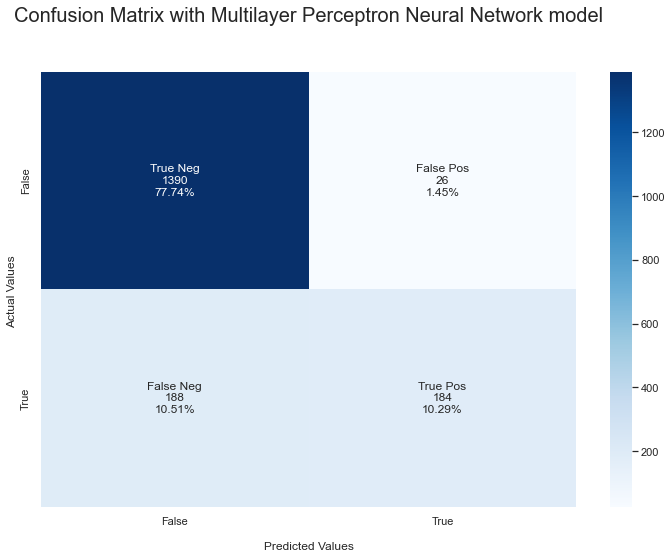

In [40]:
mlp_model = MLPClassifier()
# Training the basic Decision Tree model with training set 
mlp_model.fit(X_train,y_train)

# Predicting the output of the test cases using the algorithm created above
y_pre = mlp_model.predict(X_test)

# Validating the algorithm using various Performance metrics

a9 = accuracy_score(y_test,y_pre)
f9 = f1_score(y_test, y_pre, average="macro")
p9 = precision_score(y_test, y_pre, average="macro")
r9 = recall_score(y_test, y_pre, average="macro")
print("accuracy score : ",a9)
print("f1 score : ",f9)
print("precision score : ",p9)
print("recall score : ",r9)

# Computing Confusion matrix for the above algorithm
cf_matrix = confusion_matrix(y_test, y_pre)
plt.figure(figsize=(12,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with Multilayer Perceptron Neural Network model\n\n',fontsize=20);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

# Support Vector Machine with Scaled dataframe

accuracy score :  0.8406040268456376
f1 score :  0.6464488430389109
precision score :  0.9056285494116961
recall score :  0.6189174412247129


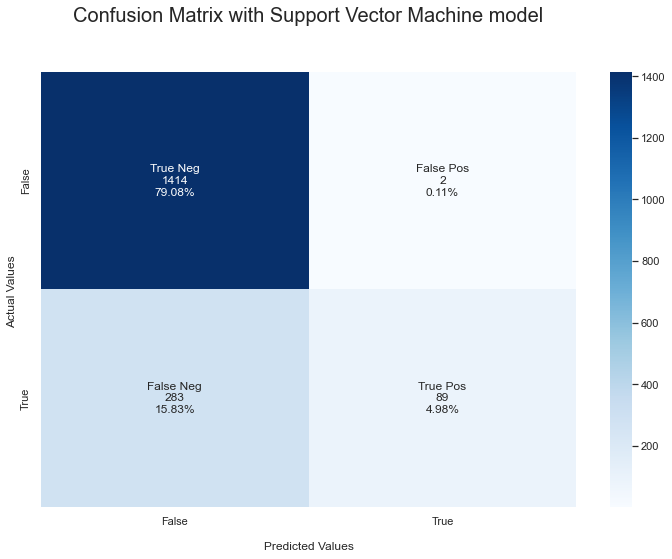

In [41]:
svc_model = SVC()
# Training the basic Decision Tree model with training set 
svc_model.fit(X_train,y_train)

# Predicting the output of the test cases using the algorithm created above
y_pre = svc_model.predict(X_test)

# Validating the algorithm using various Performance metrics

a10 = accuracy_score(y_test,y_pre)
f10 = f1_score(y_test, y_pre, average="macro")
p10 = precision_score(y_test, y_pre, average="macro")
r10 = recall_score(y_test, y_pre, average="macro")
print("accuracy score : ",a10)
print("f1 score : ",f10)
print("precision score : ",p10)
print("recall score : ",r10)

# Computing Confusion matrix for the above algorithm
cf_matrix = confusion_matrix(y_test, y_pre)
plt.figure(figsize=(12,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with Support Vector Machine model\n\n',fontsize=20);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

In [42]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree','XGBoost', 'Multilayer Perceptron','Support Vector Machine', 'Logistic Regression', 'Decision Tree','XGBoost', 'Multilayer Perceptron','Support Vector Machine'],
    'Data Scaling' : ['None','None','None','None','None','Scaled','Scaled','Scaled','Scaled','Scaled'],
    'Accuracy Score': [a1,a2,a3,a4,a5,a6,a7,a8,a9,a10],
    'Recall Score' : [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10],
    'F1 Score' : [f1,f2,f3,f4,f5,f6,f7,f8,f9,f10],
    'Precision Score' : [p1,p2,p3,p4,p5,p6,p7,p8,p9,p10]
})

In [43]:
models

,Model,Data Scaling,Accuracy Score,Recall Score,F1 Score,Precision Score
0,Logistic Regression,None,0.791946,0.500000,0.441948,0.395973
1,Decision Tree,None,0.850112,0.767621,0.770289,0.773085
2,XGBoost,None,0.911633,0.805472,0.846247,0.918486
3,Multilayer Perceptron,None,0.791387,0.499647,0.441773,0.395915
4,Support Vector Machine,None,0.793065,0.502688,0.447571,0.896417
5,Logistic Regression,Scaled,0.820470,0.595305,0.611731,0.784085
6,Decision Tree,Scaled,0.858501,0.780846,0.783365,0.785991
7,XGBoost,Scaled,0.911633,0.805472,0.846247,0.918486
8,Multilayer Perceptron,Scaled,0.880313,0.738131,0.780413,0.878526
9,Support Vector Machine,Scaled,0.840604,0.618917,0.646449,0.905629


In [44]:
pd.pivot_table(models,index = ["Data Scaling","Model"])

Accuracy Score  F1 Score  \
Data Scaling Model                                              
None         Decision Tree                 0.850112  0.770289   
             Logistic Regression           0.791946  0.441948   
             Multilayer Perceptron         0.791387  0.441773   
             Support Vector Machine        0.793065  0.447571   
             XGBoost                       0.911633  0.846247   
Scaled       Decision Tree                 0.858501  0.783365   
             Logistic Regression           0.820470  0.611731   
             Multilayer Perceptron         0.880313  0.780413   
             Support Vector Machine        0.840604  0.646449   
             XGBoost                       0.911633  0.846247   

                                     Precision Score  Recall Score  
Data Scaling Model                                                  
None         Decision Tree                  0.773085      0.767621  
             Logistic Regression            0.395973      0.500000  
             Multilayer Perceptron          0.395915      0.499647  
             Support Vector Machine         0.896417      0.502688  
             XGBoost                        0.918486      0.805472  
Scaled       Decision Tree                  0.785991      0.780846  
             Logistic Regression            0.784085      0.595305  
             Multilayer Perceptron          0.878526      0.738131  
             Support Vector Machine         0.905629      0.618917  
             XGBoost                        0.918486      0.805472

# Data Scaling helped Logistic Regression and Multilayer Perceptron perform better

**XGBoost outperformed other machine learning model**

**Next, I gonna conduct hyperparameter for XGBoost model with unscaled dataframe to get the model with highest ROC_AUC score**

In [45]:
X = df_scaled.drop(columns=["BAD"])
y = df_scaled["BAD"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =.3,random_state=1)

In [46]:
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'base_score': [0.2, 0.5, 1]
}

gs2 = GridSearchCV(XGBClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='roc_auc')
gs2.fit(X_train, y_train)

print('Best score:', gs2.best_score_)
print('Best score:', gs2.best_params_)

Best score: 0.9114128895412201
Best score: {'base_score': 0.5, 'booster': 'gbtree', 'learning_rate': 0.1, 'n_estimators': 500}


accuracy score :  0.9177852348993288
f1 score :  0.8578514166670722
precision score :  0.9275353977207321
recall score :  0.8172840349917988


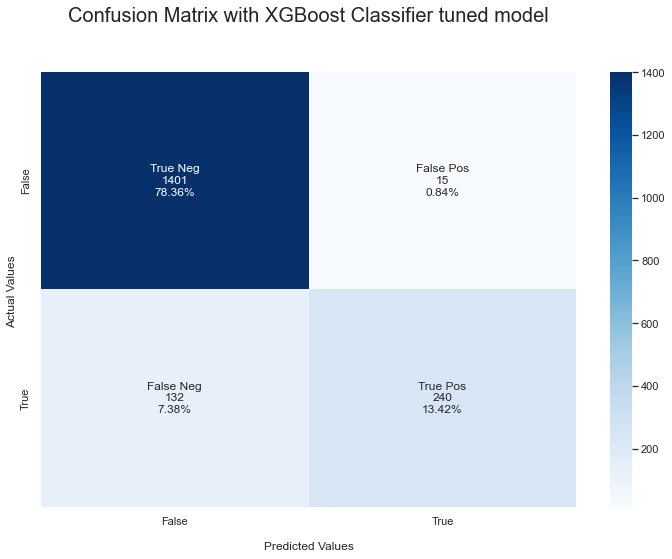

In [47]:
xgb_model_tuned = XGBClassifier(base_score= 0.5, booster= 'gbtree', 
                                learning_rate= 0.1, n_estimators= 500)
# Training the basic Decision Tree model with training set 
xgb_model_tuned.fit(X_train,y_train)

# Predicting the output of the test cases using the algorithm created above
y_pre = xgb_model_tuned.predict(X_test)

# Validating the algorithm using various Performance metrics

a = accuracy_score(y_test,y_pre)
f = f1_score(y_test, y_pre, average="macro")
p = precision_score(y_test, y_pre, average="macro")
r = recall_score(y_test, y_pre, average="macro")
print("accuracy score : ",a)
print("f1 score : ",f)
print("precision score : ",p)
print("recall score : ",r)

# Computing Confusion matrix for the above algorithm
cf_matrix = confusion_matrix(y_test, y_pre)
plt.figure(figsize=(12,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with XGBoost Classifier tuned model\n\n',fontsize=20);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

# This model will be used to Credit Scoring policy

In [48]:
importance = xgb_model_tuned.feature_importances_
column_names = list(X_train.columns)

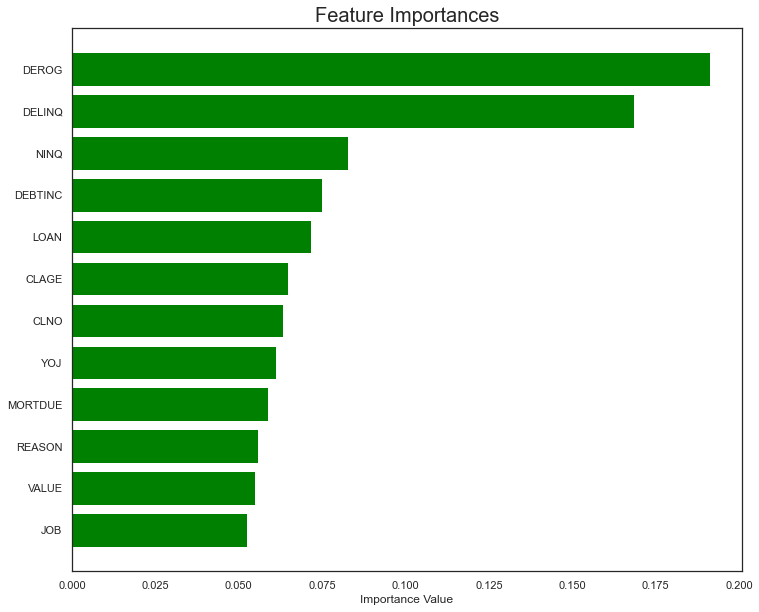

In [49]:
indices = np.argsort(importance)

plt.figure(figsize=(12,10))
plt.title('Feature Importances', fontsize=20)
plt.barh(range(len(indices)), importance[indices], color='green', align='center')
plt.yticks(range(len(indices)), [column_names[i] for i in indices])
plt.xlabel('Importance Value')
plt.show()

# Two Factors which affect probability of default are:

# 1. Number of major derogatory reports

# 2. Number of delinquent credit lines

# Bank needs to consider these two factor in process of deciding to make loan